<a href="https://colab.research.google.com/github/ariesslin/ie7500-g1-tweet-sentiment-nlp/blob/main/scripts/tweet_sentiment_analysis_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>Tweet Sentiment Analysis & Classification</strong></h2>
  <p style="color:#333333;">Using LSTM and BERT on the Sentiment140 Dataset</p>
</div>

(TODO: to be reviewed for submission)

## Motivation

In today’s digital world, platforms like X (formerly Twitter) reflect real-time public sentiment across domains — from financial markets to political discourse. Viral tweets have shaped investor behavior, brand reputation, and public policy in minutes. Traditional models in finance or decision systems often overlook this emotional layer, making them vulnerable to unanticipated shifts in public opinion.

## Problem Statement

This project aims to build a robust sentiment classifier for short, informal texts — specifically, tweets. Using the Sentiment140 dataset (1.6M tweets labeled via distant supervision), we aim to evaluate and compare classical and deep learning models to answer:

- Which architecture (TF-IDF + Logistic Regression, LSTM, or BERT) performs best on tweet sentiment classification?
- What are the trade-offs between accuracy and complexity?
- How well do models generalize to real-world, unseen tweets?

## Objective

This notebook builds a tweet sentiment classifier using the Sentiment140 dataset. We compare classical and deep learning models — TF-IDF + Logistic Regression, Bidirectional LSTM, and DistilBERT — to understand which architecture best captures sentiment in short, informal texts. Each model is evaluated in terms of accuracy, complexity, and generalizability, with the goal of identifying the most effective approach for real-world sentiment classification in domains such as finance, brand monitoring, and public feedback systems.

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>1. Data Loading & Overview</strong></h2>
  <p style="color:#333333;">Import Sentiment140 dataset and display basic information (shape, preview of data, null values, column types, etc).</p>
</div>


In [1]:
#Note: After first time installation we should restart the kernel

import sys
!{sys.executable} -m pip install -r "../requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 56.2 MB/s eta 0:00:00m eta 0:00:010:00:01


In [2]:
# importing all libraries here
import gdown
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html

The original dataset is available on Kaggle [Sentiment140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download). Since the dataset is approximately 239MB, we host it on Google Drive to simplify access and avoid GitHub’s file size limitations (maximum 100MB) for version-controlled repositories.

We use the `gdown` library to programmatically download the dataset into the local environment.

In [3]:
# Load the raw dataset
os.makedirs("../data", exist_ok=True)

url = f"https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS"
output = "../data/sentiment140.csv"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS
From (redirected): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS&confirm=t&uuid=d2eb6078-556b-403d-b3cd-90596499f904
To: /Users/ariesslin/northeastern_projects/ie7500/project/ie7500-g1-tweet-sentiment-nlp/data/sentiment140.csv
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239M/239M [00:04<00:00, 50.4MB/s]


'../data/sentiment140.csv'

In [4]:
# Naming columns for readability
columns = [
    "target",    # Sentiment (0=negative, 2=neutral, 4=positive)
    "id",        # Tweet ID
    "date",      # Date of tweet
    "flag",      # Query flag
    "user",      # Username
    "text"       # Tweet text
]

df = pd.read_csv(
    "../data/sentiment140.csv",
    encoding='latin-1',
    header=None,
    names=columns
)

In [5]:
# Show first 5 rows
df.head(5)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
# Check for null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
# Summary statistics for numeric columns
df.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [8]:
df['target'].unique()

array([0, 4])

### Dataset Overview and Initial Insights

**From `df.info()`:**
- The dataset contains **1,600,000 entries** and **6 columns**: `target`, `id`, `date`, `flag`, `user`, and `text`.
- **No missing values** in any column which indicates good structural integrity.
- **Data types**:
  - `target` and `id`: `int64`
  - `date`, `flag`, `user`, `text`: `object` (which are likely strings)

---

**From `df.describe()`:**

- **`target`**:
  - Range: 0 to 4
  - Mean = 2.0, Std = 2.0 → appears fairly balanced, but needs verification with `value_counts()`.

- **`id`**:
  - Large numeric values, probably unique identifiers (e.g., tweet IDs).
  - Not useful for prediction but useful for indexing or referencing.

---

### Initial Findings Summary

- Data integrity looks solid — **no nulls**, appropriate dtypes.
- `target` is the label column, we will need to examine and check class balance. It only contains **0 (negative)** and **4 (positive)** labels. Although the original Sentiment140 dataset defines a third class (2 = neutral), it is **not present in this version**, making this a **binary classification task**.
- The `id` column contains unique identifiers for each tweet. While useful for referencing individual entries, it is **not relevant to sentiment prediction** and can be safely dropped during data processing.
- Since all `id` values are unique, we can **confidently conclude there are no duplicate tweets**, at least in terms of tweet identity.


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>2. Exploratory Data Analysis (EDA)</strong></h2>
  <p style="color:#333333;">Analyze class distribution, tweet length, temporal trends, and tweet content structure</p>
</div>


### EDA Deep Dives into distributions

In [9]:
# Define a custom color palette for sentiment classes:
# 0 = Negative → Soft red-orange (#fc8d62)
# 4 = Positive → Muted teal green (#66c2a5)
# (Optional future: 2 = Neutral → Light blue-gray, e.g., #8da0cb)
sentiment_palette = {
    0: '#fc8d62',  # Negative sentiment
    4: '#66c2a5'   # Positive sentiment
}

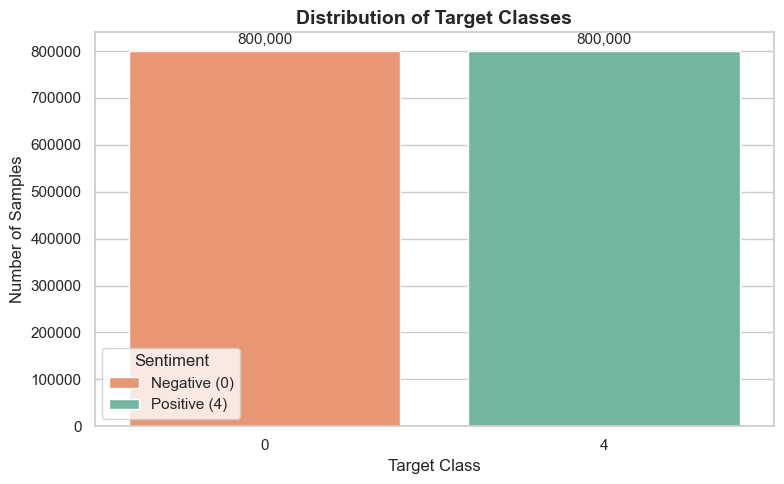

In [10]:
# we now start visualizing the distributions of the target

# Set a clean visual style
sns.set(style="whitegrid")

# Calculate value counts
target_counts = df['target'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette=sentiment_palette, legend=True)

# Add value labels on bars
for i, value in enumerate(target_counts.values):
    plt.text(i, value + max(target_counts.values)*0.01, f'{value:,}',
             ha='center', va='bottom', fontsize=11)

# Titles and labels
plt.title('Distribution of Target Classes', fontsize=14, fontweight='bold')
plt.xlabel('Target Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

# Customize the legend labels
# Get the legend object
handles, labels = barplot.get_legend_handles_labels()

# Create a dictionary to map old labels (0, 4) to new labels ('Negative', 'Positive')
new_labels = {'0': 'Negative (0)', '4': 'Positive (4)'}

# Update the labels in the legend
updated_labels = [new_labels[label] for label in labels]
barplot.legend(handles, updated_labels, title="Sentiment")

plt.show()

#### Bar Chart Distribution Insight:

Despite the Kaggle description suggesting that the dataset includes three sentiment classes (positive, negative, and neutral), this chart reveals that the annotations are limited to only two classes:

0: Negative sentiment

4: Positive sentiment

There are no neutral (class 2) samples present in this dataset.
Additionally, the distribution appears to be perfectly balanced, with approximately 800,000 samples in each class. This is ideal for training a binary classifier, as it minimizes issues related to class imbalance.

### Temporal Trends Analysis

In [11]:
# Remove timezone string (e.g., "PDT") to avoid parsing issues
df['date'] = df['date'].str.replace(r' [A-Z]{3} ', ' ', regex=True)

# Fix and convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create a new column for year
df['year'] = df['date'].dt.year

df.head()

,target,id,date,flag,user,text,year
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009


In [12]:
df['year'].unique()

array([2009], dtype=int32)

This indicates that all tweets in the dataset are from 2009

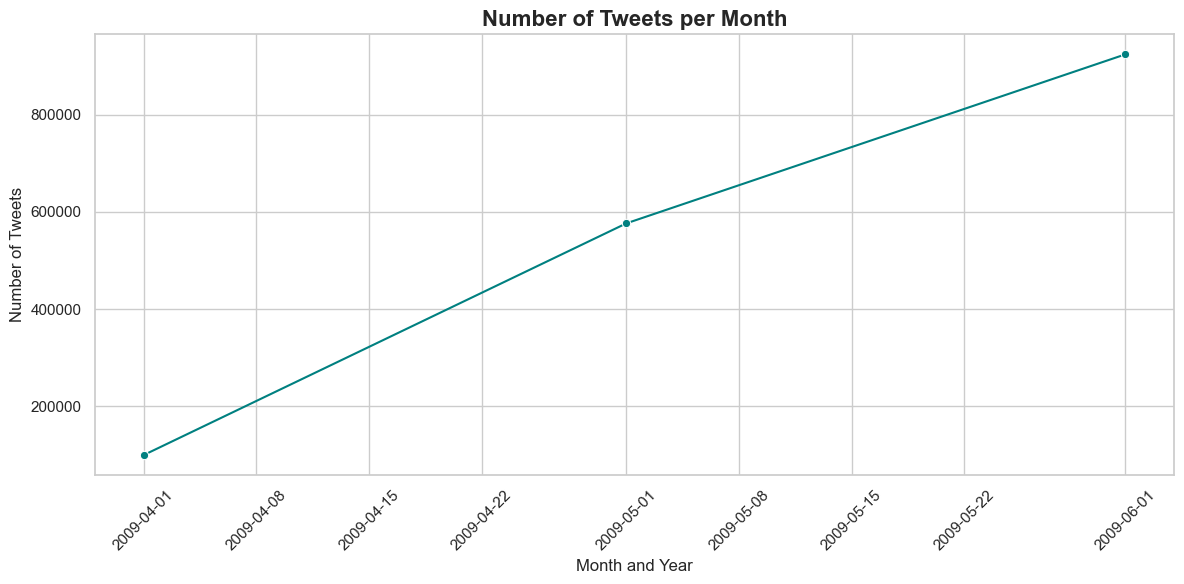

In [13]:
# We now examine the number of tweet samples we have by month and year

# Create the 'year_month' column
df['year_month'] = df['date'].dt.to_period('M').astype(str)

# Group by year_month and count tweets
monthly_counts = df.groupby('year_month').size().reset_index(name='tweet_count')

# Set style
sns.set(style='whitegrid')

# Convert year_month to datetime for proper ordering in the x-axis
monthly_counts['year_month'] = pd.to_datetime(monthly_counts['year_month'])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='year_month', y='tweet_count', marker='o', color='teal')

# Labels and title
plt.title("Number of Tweets per Month", fontsize=16, fontweight='bold')
plt.xlabel("Month and Year", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Line Plot Insight for Tweet Volume Over Time

This line chart shows the number of tweets collected over time based on the Sentiment140 dataset.

From the visualization, we observe that the tweets were collected over a short time span — specifically over a period of **approximately three months in 2009**.

- The dataset begins in **April 2009** and ends by **early June 2009**, suggesting a **single batch collection** during that year.
- The dataset spans only a short period (April–June 2009), so **any temporal or trend-based analysis (e.g., changes in sentiment over time) should be interpreted with caution**. Since it does not cover a full year or multiple time periods, apparent trends may reflect sampling patterns rather than true sentiment shifts.
- We observe a steady increase in tweet volume over time, which likely reflects the organic growth of Twitter’s user base during its early expansion phase in 2009.


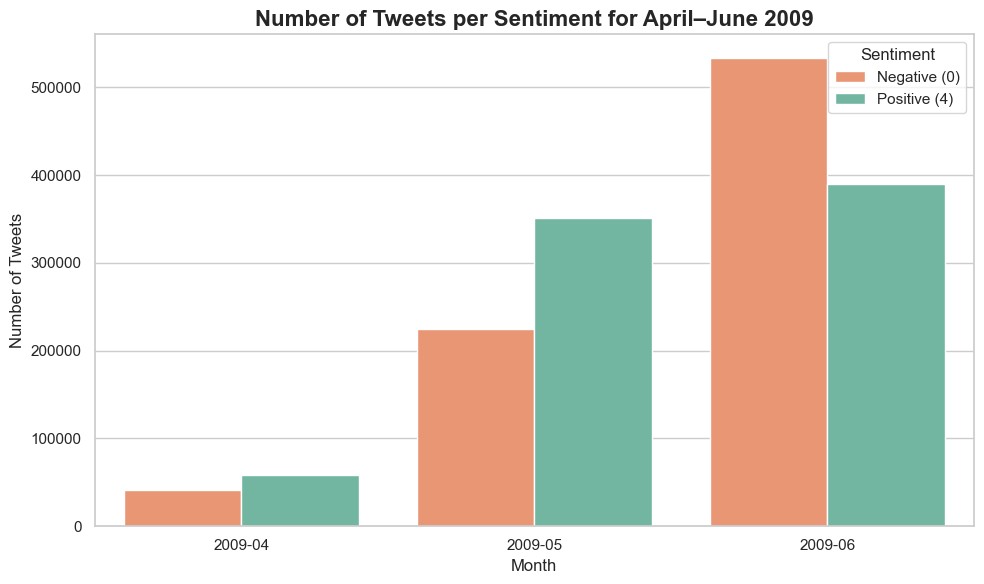

In [14]:
# Examine tweets distribution by month

# Count tweets by month and target
monthly_sentiment_counts = (
    df.groupby(['year_month', 'target'])
    .size()
    .reset_index(name='tweet_count')
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=monthly_sentiment_counts,
    x='year_month', y='tweet_count', hue='target',
    palette=sentiment_palette
)

# Labels and title
plt.title('Number of Tweets per Sentiment for April–June 2009', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

# Fix legend to match colors and labels
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Negative (0)', 'Positive (4)'], title='Sentiment')

plt.tight_layout()
plt.show()


#### Key Insights on Number of Tweets per Sentiment for April–June 2009

This bar chart visualizes the number of tweets labeled as **negative (0)** and **positive (4)** across the three months covered by the dataset: **April, May, and June 2009**.

- Tweet volume **increased steadily each month**, peaking in June 2009.
- In **April**, tweet volume was relatively low and slightly favored **positive sentiment**.
- In **May**, the number of tweets grew substantially, with a notable rise in **positive tweets**.
- By **June**, the volume of **negative tweets** overtook positive ones, reaching the highest count in the dataset.

This temporal breakdown shows both an overall **growth in Twitter samples collected** and **variation in sentiment dynamics** during this short collection window.


### Tweet Length Analysis

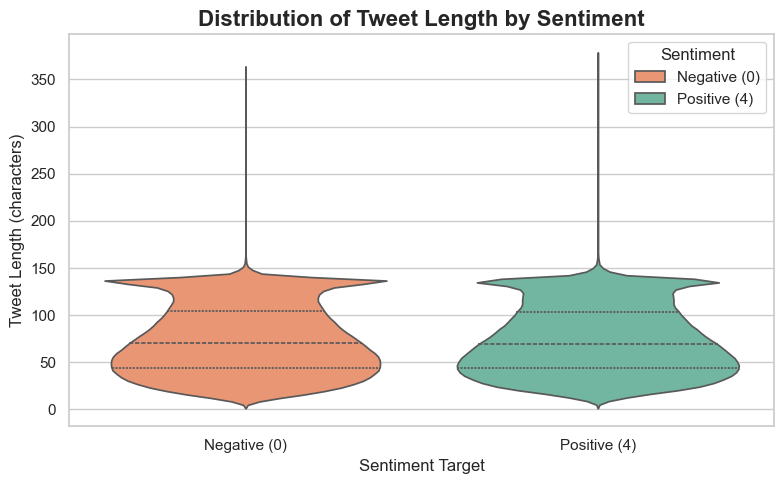

In [15]:
# We now visualize the violin plot for each target by tweet length

# Add a new column for tweet length
df['text_length'] = df['text'].str.len()

# Violin plot of tweet length by sentiment
plt.figure(figsize=(8, 5))
ax = sns.violinplot(data=df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=True)

plt.title("Distribution of Tweet Length by Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Sentiment Target", fontsize=12)
plt.ylabel("Tweet Length (characters)", fontsize=12)
plt.xticks([0, 1], ["Negative (0)", "Positive (4)"], fontsize=11)

# Fix legend to match custom labels
legend = ax.get_legend()
legend.set_title('Sentiment')
handles, labels = legend.legend_handles, [t.get_text() for t in legend.get_texts()]
label_map = {'0': 'Negative (0)', '4': 'Positive (4)'}
new_labels = [label_map.get(l, l) for l in labels]
for t, new_label in zip(legend.get_texts(), new_labels):
    t.set_text(new_label)

plt.tight_layout()
plt.show()

#### Insights on Distribution of Tweet Length by Sentiment

This violin plot illustrates the distribution of tweet lengths (in characters) for each sentiment class in the dataset:

- **Negative tweets (target = 0)**  
- **Positive tweets (target = 4)**

Key observations:
- The **distribution shapes** for both sentiments are fairly similar, suggesting that tweet length is not strongly associated with sentiment polarity.
- Most tweets fall within the **50 to 120 character** range for both classes.
- There are a few **longer tweets (up to ~360 characters)**, but they are rare and do not skew the distribution significantly.
- The **thickness of the violin** indicates the density — most tweets cluster around the 40–100 character range.

Conclusion:  
Tweet length appears to have a **amost exact pattern** across both positive and negative sentiments, and is therefore unlikely to be a strong discriminative feature on its own.


#### Tweet Length Anomaly: Why Do Some Tweets Exceed 140 Characters?

According to Twitter's original design, tweets were limited to **140 characters** in 2009 — the same year the **Sentiment140 dataset** was collected. Therefore, we would expect all tweets in the dataset to adhere to this limit.

Here are several plausible explanations for why we see tweets longer than expected:

1. **Concatenated Content**:
   - Some entries might include quoted replies or accidentally merged tweets during data collection.

2. **Unremoved Artifacts**:
   - Elements like URLs, emojis, or user mentions (`@username`) could inflate character counts if not properly cleaned before measurement.

3. **Invisible Characters**:
   - Special characters such as newline characters (`\n`), Unicode symbols, or HTML entities may not be visible but still count toward `.str.len()`.

4. **Data Corruption or Preprocessing Errors**:
   - Poor delimiter handling or formatting issues during scraping could cause multiple tweets to merge into one row.


To better understand what is causing the longer tweet lengths, we inspect the first few tweets that exceed the 140-character limit:

In [16]:
# Count how many tweets are longer than 140 characters
num_long_tweets = df[df['text_length'] > 140].shape[0]
print(f"Number of tweets longer than 140 characters: {num_long_tweets}")

Number of tweets longer than 140 characters: 17174


In [17]:
# Disable truncation in display
pd.set_option('display.max_colwidth', None)

# Sort by tweet length and show the top 10 longest tweets
df.sort_values(by='text_length', ascending=False)[['text', 'text_length']].head(10)

,text,text_length
1295281,@catfish_ohm à¹à¸à¹à¸²à¹à¸«à¹à¸?à¸²à¸£à¹à¸à¸¹à¸à¸?à¸¸à¹à¸£à¸°(à¸ªà¸±à¸ªà¹+à¸¢à¸¹à¸£à¸´à¹?à¸?à¹à¸à¹à¹?à¸à¸à¸à¸°à¸à¸­à¸à¸µà¸¡à¸´à¹à¸?à¸°à¸«à¸§à¸(à¸à¸à¸²à¸à¹à¸à¸´à¸à¹?à¸?à¸¢à¸±à¸à¹à¸à¸¢à¹à¸«à¹à¹à¸¡à¹à¹à¸à¹à¹à¸«à¸£à¸­.à¹?à¸à¹à¸à¹à¸²à¸à¹à¸«à¸­à¸°à¸£à¸²à¸¢à¸à¸±à¹à¸à¹à¸à¸²à¹à¸¡à¹à¸­à¸°à¸?à¸§à¹à¸²à¸à¸¥à¸²à¹?à¸¡à¸§à¹à¸¢à¸­à¸° =,374
1484882,@iannnnn à¹à¸à¸µà¹à¸¢à¸§à¸­à¸µà¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸à¹à¸£à¸µà¸¢à¸?à¸à¸µà¸¡ Graphic à¹à¸à¹à¸²à¸¡à¸²à¹?à¸¥à¹à¸§à¸à¸£à¸±à¸à¹à¸¥à¹à¸?à¸à¹à¸­à¸¢à¹à¸«à¹à¸¡à¸±à¸à¸à¸¥à¹à¸²à¸¢à¸?à¸±à¸à¸¢à¸´à¹à¸à¸à¸¶à¹à¸à¸à¸£à¸±à¸ à¹à¸à¸£à¸²à¸°à¸«à¸²à¸?à¹à¸­à¸²à¸¡à¸²à¹à¸à¸µà¸¢à¸à¸?à¸±à¸à¸à¸à¸¡à¸µà¸à¸±à¸?à¸«à¸²à¸­à¸¢à¹à¸²à¸à¸§à¹à¸²à¸à¸£à¸±à¸.,369
380539,@neospace à¹à¸£à¸·à¹à¸­à¸à¸à¸±à¹à¸à¸à¸£à¸£à¸à¹à¸à¸£à¸² à¹à¸«à¹à¸à¸à¹à¸§à¸¢à¸à¸µà¹à¹à¸¡à¹à¸à¹à¸­à¸à¹à¸à¸à¸±à¹à¸à¹à¹à¸¥à¹à¸à¸?à¸²à¸£à¹à¸¡à¸·à¸­à¸ &quot;à¸à¹à¸²à¸à¸à¸à¸&quot; à¸?à¸±à¸à¸­à¸µà¸? à¹?à¸à¹à¸à¸µà¹à¸¡à¸²à¸à¸µà¹à¹à¸à¹à¸«à¹à¸à¹?à¸¥à¹à¸§ à¸à¸±à¸à¸à¸²à¸¡à¸²à¸? à¸à¸£à¸£à¸à¹à¸à¸µà¸¢à¸§ Green Party,359
1582941,5 days till new top gear î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?î?,359
650945,human shield à®à®©à¯?à®± à®à¯à®±à¯?à®¤à¯à®à®°à¯ à®à®©à¯?à®±à¯? à®®à®±à¯?à®ªà®à®¿à®¯à¯?à®®à¯? à®à®à®à®à¯?à®à®³à®¿à®²à¯? (à®®à¯à®±à¯?à®à¯? à®µà®à¯?à®à®®à¯?) à®¤à¯à®à®°à¯?à®ªà®¾à® à®ªà®¾à®°à¯?à®¤à¯?à®¤ à®ªà¯à®¤à¯? à®à®´à¯?à®¨à¯?à®¤ à®à®£à®°à¯?à®µà®¿à®±à¯?à®à¯? à®ªà¯à®¯à®°à¯? à®à¯à®²à¯?à®² à®¤à¯à®°à®¿à®¯à®µà®¿à®²à¯?à®²à¯,348
1450935,@KaewGB à¸­à¹à¸­ à¹à¸à¸¢à¸à¸²à¸¡à¹à¹à¸à¸à¸µà¹à¸«à¸¥à¸²à¸¢à¸à¸£à¸±à¹à¸ à¹à¸¡à¹à¸¡à¸µà¹à¸à¸£à¸à¸¹à¸à¸à¸£à¸°à¹à¸à¹à¸à¸à¸µà¹ 55 à¸¡à¸µà¹?à¸à¹ à¹à¸à¹à¸²à¹à¸à¹à¸ resource à¹à¸ KU à¸à¹à¸²à¸ à¹à¸¡à¹à¸?à¹à¹à¸¥à¹à¹à¸«à¹à¹à¸à¹à¸à¸´à¸à¸§à¹à¸² VPN à¸¢à¹à¸­à¸¡à¸²à¸à¸²à¸?à¸­à¸°à¹à¸£ =v=,328
1358216,@thanr à¹à¸à¸µà¹à¸¢à¸§à¹à¸­à¸²à¸£à¸²à¸à¸²à¹à¸à¸©à¸à¸²à¸­à¸­à¸?à¸à¸£à¸±à¸ à¸®à¸²à¹ ... à¹à¸à¸£à¸²à¸°à¸§à¹à¸²à¸¡à¸±à¸à¹à¸¡à¹à¸à¸£à¸à¸£à¸²à¸à¸²à¹à¸¥à¸¢à¸à¸£à¸±à¸ ... à¸­à¸±à¸à¸à¸µà¹à¸¥à¸­à¸à¹à¸ªà¹à¸à¸à¸ªà¸­à¸à¸à¸¹à¸à¸£à¸±à¸ à¹à¸à¸µà¹à¸¢à¸§à¹à¸­à¸²à¸­à¸­à¸?à¸à¸±à¸?à¸à¸£à¸¹à¹à¸à¸£à¸±à¸,326
1264121,"@msathia à®®à¯?à®¹à¯à®®à¯?, à®ªà®¯à®®à¯?à®±à¯?à®¤à¯?à®¤à¯?à®¤à¯?, à®à®¤à¯à®ªà¯?à®ªà®±à¯?à®±à®¿ à®à®à¯?à®à¯à®¯à®¾à®µà®¤à¯? à®à®´à¯?à®¤à®²à®¾à®®à®¾à®©à¯?à®©à¯? à®¯à¯à®à®©à¯, à®à®©à®¾ à®ªà¯à®¯à®°à¯? à®à®°à®¿à®¯à®¿à®²à¯?à®²à®¾à®à¯?à®à®¿ à®¯à®¾à®°à¯?à®®à¯? 2 à®µà®°à®¿ à®¤à®¾à®£à¯?à®à®®à®¾à®à¯?à®à®¾à®à¯?à®",323
1319230,@laches [æçèª å¯¦å ­ååæ¶] æè¿è·ä¸åä¸­åæå?è?å ­åï¼å°¤å ¶ææ?æ?ï¼å çºä»çç¶è¦ªä¾¿æ¯è¶ç´«é½ç¶å¹´èº«éçç§æ¸ï¼è·èè¶ç´«é½ä¸èµ·è¢«æææ¬åãä»èªªï¼ä»ç¶è¦ªå ¶å¯¦ä¸¦ä¸?ççèª?è­æ°ä¸»ï¼è ¦è¢è£¡æ´å¤çæ¯ãå ±ç¢é»¨è² æã?çææ?¨ã.. http://tr.im/ngdo,314
1397388,ê·¼ë?° ë¡ë°¥ì?´ìì¼ë ì± ìì§ê³ ë ë¤í°ì¦ ì¬ê³¼íê³ ê·¸ë¬ë ë¶ë¤ì?´ ê¼­ ê³ìê±°ë ì... hitdg@chanjin ì¿ í¤ë´ì¤ë³´ê³ ì°¬ì§ë í¸ìê¸ì?´ ë¡íë ìë ê±° ë³´ê³ ëë?ìµëë¤. ì?´ê².í¸ìì? íì?´êµ¬ë ì¤ê°?íì£ .ì  ì°¬ì§ëì?´ ì± ìì§ ì?´ì ìë¤ê³ ë³´ëë?°ì...,313


The garbled characters in tweet text column indicate encoding issues, the text was likely saved or loaded using the wrong character encoding (commonly ISO-8859-1, cp1252, or utf-16) instead of the correct one (often utf-8 for Twitter data).

To fix this issue, we adjust data loading to encorporate for such encodings, and re-run some of the EDA sections again for verification.

In [18]:
# Step 1: Create data directory and download the file
os.makedirs("../data", exist_ok=True)

url = "https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS"
output = "../data/sentiment140.csv"

gdown.download(url, output, quiet=False)

# Step 2: Define column names
columns = [
    "target",    # Sentiment (0=negative, 2=neutral, 4=positive)
    "id",        # Tweet ID
    "date",      # Date of tweet
    "flag",      # Query flag
    "user",      # Username
    "text"       # Tweet text
]

# Step 3: Load with proper encoding
df_fixed = pd.read_csv(output, encoding='latin-1', header=None, names=columns)

# Step 4: Fix any garbled characters in 'text' if needed
df_fixed["text"] = df_fixed["text"].apply(lambda x: x.encode("latin1").decode("utf-8", errors="ignore") if isinstance(x, str) else x)

# Step 5: Preview result
print(df_fixed["text"].head())

Downloading...
From (original): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS
From (redirected): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS&confirm=t&uuid=c713585c-48cc-4b96-acd8-9095e7b977cf
To: /Users/ariesslin/northeastern_projects/ie7500/project/ie7500-g1-tweet-sentiment-nlp/data/sentiment140.csv
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239M/239M [00:02<00:00, 85.2MB/s]


0    @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
1        is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
2                              @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
3                                                                        my whole body feels itchy and like its on fire 
4        @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Name: text, dtype: object


#### Text Encoding Fix and Next Cleaning Step

The tweet text has been successfully decoded from its original garbled format caused by incorrect character encoding. We used the correct `latin-1` encoding along with a decoding fix to restore readable text.

However, the text still contains **HTML-escaped characters**, such as:

- `&quot;` for double quotes `"`,  
- `&amp;` for ampersand `&`,  
- `&lt;`, `&gt;` for `<` and `>` respectively.

These are not raw special characters but **escaped entities**, which need to be decoded for clean and normalized text. This is essential for proper tokenization and accurate sentiment classification.

**for data preprocessing step step**: Use `html.unescape()` from Python’s built-in `html` module to convert all HTML entities back to their intended characters before further preprocessing.


In [19]:
# we now decode HTML-escaped entities like &quot;, &amp;, etc.
df_fixed['text'] = df_fixed['text'].apply(lambda x: html.unescape(x) if isinstance(x, str) else x)


In [20]:
# Count how many tweets are longer than 140 characters

df_fixed['text_length'] = df_fixed['text'].apply(len)

num_long_tweets = df_fixed[df_fixed['text_length'] > 140].shape[0]
print(f"Number of tweets longer than 140 characters: {num_long_tweets}")

Number of tweets longer than 140 characters: 0


In [21]:
df_fixed['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()


0

In [22]:
# Disable truncation in display
pd.set_option('display.max_colwidth', None)

# Sort by tweet length and show the top 10 longest tweets
df_fixed.sort_values(by='text_length', ascending=False)[['text', 'text_length']].head(10)

,text,text_length
1462693,"i am NOT liking the ""big-curly-hair-with-the-braids"" look :/ im not taking my braids out! i will just simply straighten my hair once more",138
1402277,Woke up to a storm outside...Florida gets on my nerves sometimes...the state not the lady from Good Times...except the episode when...nvm,138
1307540,"@ohmishka I thought it was such a great idea too, she said she would rather support independent artists than give her $ to big companies.",138
805844,"I like penis: Ok so backup only was not enough for you pussys, HERE, have some credit cards too You know, it'.. http://tinyurl.com/d356b3",138
805840,"Selling DILDO in a box: Ok so backup only was not enough for you pussys, HERE, have some credit cards too You.. http://tinyurl.com/ca2ecn",138
1111822,"http://twiturm.com/vew6 I made this mix just for fun. I used to live w/ 1 of the BCR (not as a bf) though in Lake Forest, CA. Trying ...",138
975039,"@chiropractic ha! you are my hero. weekend stats looking good over here, lots of people dreading their job come monday, searching 4 new 1",138
252190,Is finally back from London after being stuck in traffic for about 5 hours! I now have hardly any time to get work done. Long night ahead,138
626735,@brennygee Looks like the twitterverse disagrees with you I just figured my first iPod was white- I thought I'd be kicking it old school.,138
1307506,"yup its going to be @TaqiyyaLuvLa @10marion @officialTila @Tyrese4Real @Willie_Day26 @souljaboytellem and many more tonight,fun... lol jk",138


In [23]:
pd.reset_option('display.max_colwidth')

#### Now we resume with EDA, re-iterating over some which we have already done


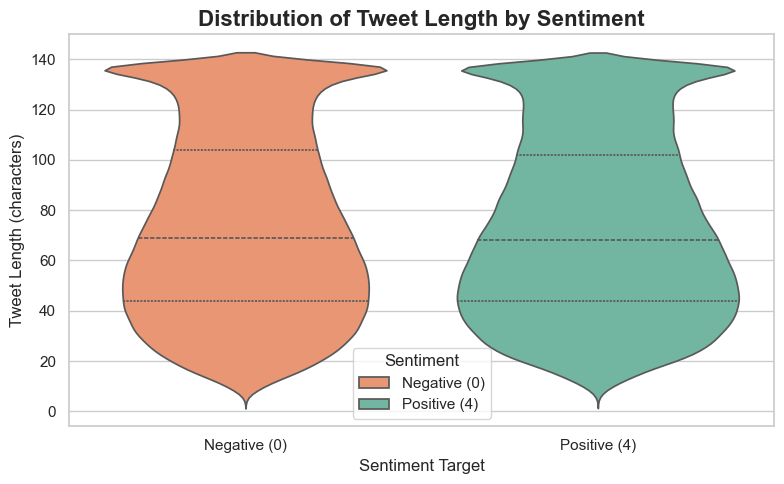

In [24]:
# We now visualize again the violin plot for each target by tweet length

# Add a new column for tweet length
df_fixed['text_length'] = df_fixed['text'].str.len()

# Violin plot of tweet length by sentiment
plt.figure(figsize=(8, 5))
ax = sns.violinplot(data=df_fixed, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=True)

plt.title("Distribution of Tweet Length by Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Sentiment Target", fontsize=12)
plt.ylabel("Tweet Length (characters)", fontsize=12)
plt.xticks([0, 1], ["Negative (0)", "Positive (4)"], fontsize=11)

# Fix legend to match custom labels
legend = ax.get_legend()
legend.set_title('Sentiment')
handles, labels = legend.legend_handles, [t.get_text() for t in legend.get_texts()]
label_map = {'0': 'Negative (0)', '4': 'Positive (4)'}
new_labels = [label_map.get(l, l) for l in labels]
for t, new_label in zip(legend.get_texts(), new_labels):
    t.set_text(new_label)

plt.tight_layout()
plt.show()

/var/folders/5m/q16b86r92zgbmjpxpdx4ghfw0000gn/T/ipykernel_1799/862403846.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_counts = df_fixed.groupby(['length_bucket', 'target']).size().reset_index(name='count')


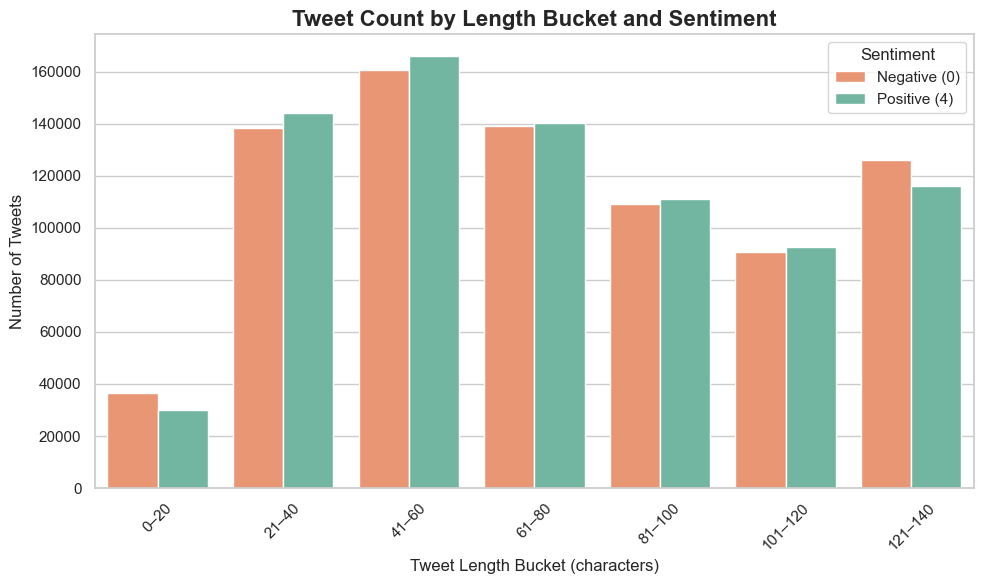

In [25]:
# We now examine tweet length and sentiment


# Define adjusted bins based on observed distribution
bin_edges = [0, 20, 40, 60, 80, 100, 120, 140]
bin_labels = ['0–20', '21–40', '41–60', '61–80', '81–100', '101–120', '121–140']

# Create tweet length buckets
df_fixed['length_bucket'] = pd.cut(df_fixed['text_length'], bins=bin_edges, labels=bin_labels, right=True)

# Group by bucket and sentiment, then count
bucket_counts = df_fixed.groupby(['length_bucket', 'target']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=bucket_counts,
    x='length_bucket',
    y='count',
    hue='target',
    palette=sentiment_palette
)

# Update legend labels
label_map = {0: 'Negative (0)', 4: 'Positive (4)'}
handles, labels = ax.get_legend_handles_labels()
new_labels = [label_map.get(int(label), label) for label in labels]
ax.legend(handles, new_labels, title="Sentiment")

# Axis labels and formatting
plt.title("Tweet Count by Length Bucket and Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Tweet Length Bucket (characters)", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# Counting the number of tweets with special characters, and those that are a response to other users

# Define a regex pattern for special characters (excluding whitespace and alphanumerics)
special_char_pattern = r"[^\w\s]"  # matches anything that's not a-z, A-Z, 0-9, or whitespace

# Count tweets that contain at least one special character
num_special_chars = df_fixed['text'].str.contains(special_char_pattern).sum()

# Count tweets that start with a mention (starts with '@')
num_mentions = df_fixed['text'].str.startswith('@').sum()

# Output
print(f"Number of tweets with special characters: {num_special_chars:,}")
print(f"Number of tweets that are mentions (start with @): {num_mentions:,}")


Number of tweets with special characters: 1,449,479
Number of tweets that are mentions (start with @): 698,079


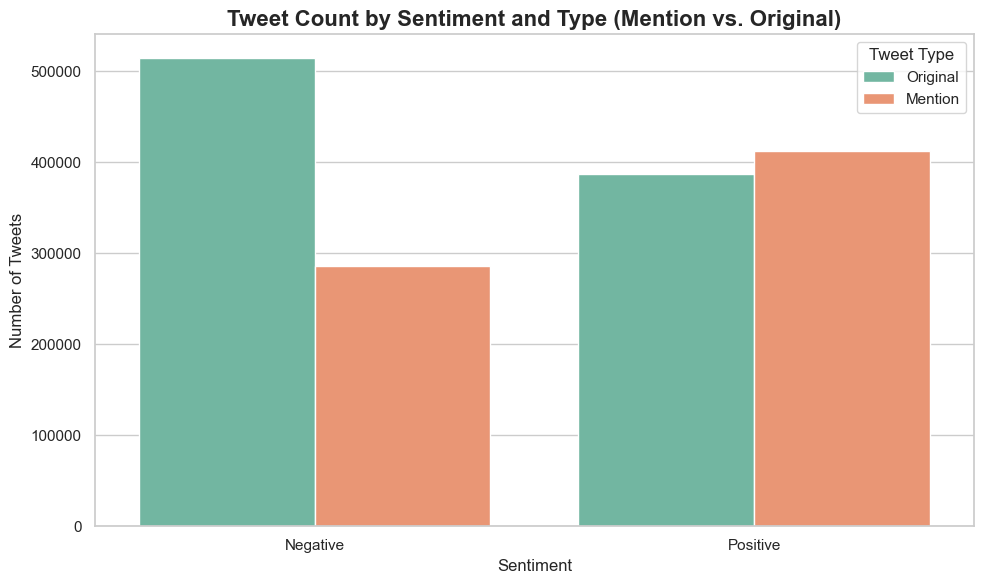

In [27]:
# Now we examine if any pattern arises if the tweet is a response/mention or not

# Create a boolean column: True if tweet starts with '@', else False
df_fixed['is_mention'] = df_fixed['text'].str.startswith('@')

# Group by sentiment (target) and mention status
mention_sentiment_counts = (
    df_fixed.groupby(['target', 'is_mention'])
    .size()
    .reset_index(name='tweet_count')
)

import seaborn as sns
import matplotlib.pyplot as plt

# Define labels for the sentiment and mention columns
mention_sentiment_counts['Sentiment'] = mention_sentiment_counts['target'].map({0: 'Negative', 4: 'Positive'})
mention_sentiment_counts['Tweet Type'] = mention_sentiment_counts['is_mention'].map({True: 'Mention', False: 'Original'})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=mention_sentiment_counts,
    x='Sentiment', y='tweet_count', hue='Tweet Type',
    palette='Set2'
)

# Labels and title
plt.title('Tweet Count by Sentiment and Type (Mention vs. Original)', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.legend(title='Tweet Type')
plt.tight_layout()
plt.show()

## General EDA Summary

- The dataset comprises **1.6 million labeled tweets**, split evenly between **positive (target = 4)** and **negative (target = 0)** sentiments.
- There are **no missing or malformed values** across any of the six columns: `target`, `id`, `date`, `flag`, `user`, and `text`. This indicates excellent data quality and readiness for downstream processing.
- The **sentiment distribution is perfectly balanced**, with approximately **800,000 samples in each class**. This lack of class imbalance is ideal for training binary classifiers without the need for resampling.
- A violin plot of tweet lengths reveals that both sentiment classes have similar distributions, with most tweets falling in the **20–70 character** range. This implies that **tweet length does not correlate strongly with sentiment**, reducing the risk of unintended bias during modeling.
- Temporal analysis shows that the tweets were collected within a short time span — from **April to June 2009**. Although there is a noticeable increase in tweet volume across these months, the **sentiment proportions remain consistent**, suggesting this variation has **minimal effect on learning or sentiment classification**.
- When breaking down tweets by **type of interaction** (original tweets vs. replies/mentions that begin with `@`), an interesting pattern emerges:
  - **Negative tweets are more likely to be original posts**, while
  - **Positive tweets are more often replies or mentions** to other accounts.
  
  This behavioral difference suggests that **positive sentiment may be more common in interpersonal or interactive tweets**, whereas **negative sentiment might be more frequently expressed in stand-alone posts**. This subtle distinction could have implications for contextual sentiment modeling.

Overall, the dataset is **clean, balanced, and well-structured**, making it a strong foundation for robust sentiment classification using classical or deep learning techniques.


## Key Note

During EDA, we observed a behavioral difference between tweet types:
- **Negative tweets are more likely to be original posts**
- **Positive tweets more frequently occur as replies or mentions (starting with `@`)**

To avoid discarding this valuable context during text preprocessing and to enhance model learning, we will not directly discard @ and lose valuable information.



## Plan to Leverage Tweet Interaction Type (Mentions vs. Original) for NLP Sentiment Classification

- Replace usernames (e.g., `@user123`) with a neutral token like `[USER]`.
- This keeps the context of interaction (e.g., replying to someone) without overfitting to specific handles.

```python
df['clean_text'] = df['text'].str.replace(r'^@\w+', 'MENTION', regex=True)
```


- Create an Explicit Feature column: is_mention

This results in capturing conversational context, which might influence sentiment.




<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>3. Data Preprocessing</strong></h2>
  <p style="color:#333333;">Steps: lowercasing, punctuation & stopword removal, tokenization, stemming, lemmatization, cleaning hashtags, mentions, URLs, numbers.</p>
</div>


- Convert Upper case words to Lower Case
- Change all mentions and charachters attached into "MENTION"
- Download stopwords, punkt_tab using nltk.download() function.
- for the stop_words add punctuations like , . " '
- Remove White space

In [28]:
# importing all libraries here
import numpy as np
import pandas as pd
import gdown
import os
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TreebankWordTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re
import spacy

In [29]:
#from google.colab import files

In [30]:
# Download the stopwords and punkt_tab
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ariesslin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
!python -m spacy download en_core_web_lg

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.8.0/en_core_web_lg-3.8.0-py3-none-any.whl (400.7 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [32]:
# step 1, Convert all cases to lower

tweets = df_fixed[['text', 'target']]

tweets['text'] = tweets['text'].str.lower()

tweets.head()

/var/folders/5m/q16b86r92zgbmjpxpdx4ghfw0000gn/T/ipykernel_1799/2406542833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['text'] = tweets['text'].str.lower()


,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [33]:
# step 2, convert all mentions and the mentioned account names to MENTION

# Make a copy to avoid modifying the original DataFrame
tweets = df_fixed[['text', 'target']].copy()

# Convert to lowercase
tweets['text'] = tweets['text'].str.lower()

# Replace all @mentions with "MENTION"
tweets['text'] = tweets['text'].str.replace(r'@\w+', 'MENTION', regex=True)

tweets.head()

,text,target
0,"MENTION http://twitpic.com/2y1zl - awww, that'...",0
1,is upset that he can't update his facebook by ...,0
2,MENTION i dived many times for the ball. manag...,0
3,my whole body feels itchy and like its on fire,0
4,"MENTION no, it's not behaving at all. i'm mad....",0


In [34]:
tweets['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()

0

In [35]:
# Step #3, we tokenize the words and remove stop words

nltk.download('wordnet')

# Load NLP model
nlp = spacy.load('en_core_web_lg')

# Setup
tokenizer = TreebankWordTokenizer()
tweets_array = tweets.to_numpy(copy=True)
stop_words = set(stopwords.words('english'))

# Add extra symbols to stop words
stop_words.update(string.punctuation)
stop_words.update(["''", "'", '``', '’', '“', '”','–', '—', '…', '..', '.', ',', ':', ';', '?', '!', '(', ')', '[', ']', '{', '}', '/', '|'])

# Stemmers / lemmatizers
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Preprocess each tweet
for i in range(len(tweets_array)):
    text = tweets_array[i][0]  # Access the tweet text

    # Remove numbers and whitespace
    text = ''.join((z for z in text if not z.isdigit()))
    text = ' '.join(text.split())

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Protect MENTION placeholder
    if 'MENTION' in text:
        text = text.replace('MENTION', '<<MENTION>>')

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Restore MENTION
    text = text.replace('<<MENTION>>', 'MENTION')

    # Tokenize using TreebankWordTokenizer
    tokens = tokenizer.tokenize(text)

    # Remove stopwords but keep MENTION
    tokens = [word for word in tokens if word not in stop_words or word == 'MENTION']

    # Lemmatize (skip MENTION)
    tokens = [lemmatizer.lemmatize(word.lower()) if word != 'MENTION' else word for word in tokens]

    # Rejoin
    tweets_array[i][0] = ' '.join(tokens)

# Convert back to DataFrame
preprocessed_tweets = pd.DataFrame(tweets_array, columns=['text', 'target'])
preprocessed_tweets.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,target
0,MENTION thats bummer shoulda got david carr th...,0
1,upset cant update facebook texting might cry r...,0
2,MENTION dived many time ball managed save rest...,0
3,whole body feel itchy like fire,0
4,MENTION behaving im mad cant see,0


In [36]:
preprocessed_tweets['text'].apply(lambda x: pd.isna(x) or str(x).strip() == '').sum()

505

**we have around 500 "new" null text cells introduced after removing stop words. they will be deleted later as a first step before sampling training, validation and testing data**

#### Here we view word cloud of tweets for negative and positive marks

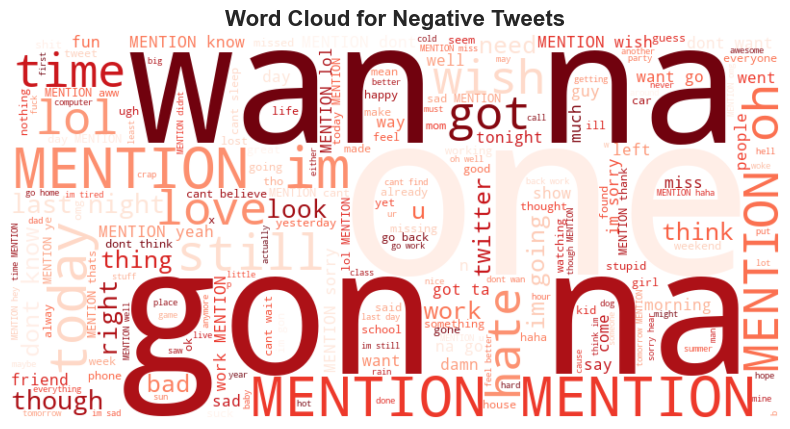

In [37]:
# Negative Tweets word cloud

# Filter only negative tweets (target == 0)
negative_tweets = preprocessed_tweets[preprocessed_tweets['target'] == 0]['text']

# Combine all negative tweet text into a single string
text_blob = ' '.join(negative_tweets.astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=200
).generate(text_blob)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Negative Tweets", fontsize=16, fontweight='bold')
plt.show()

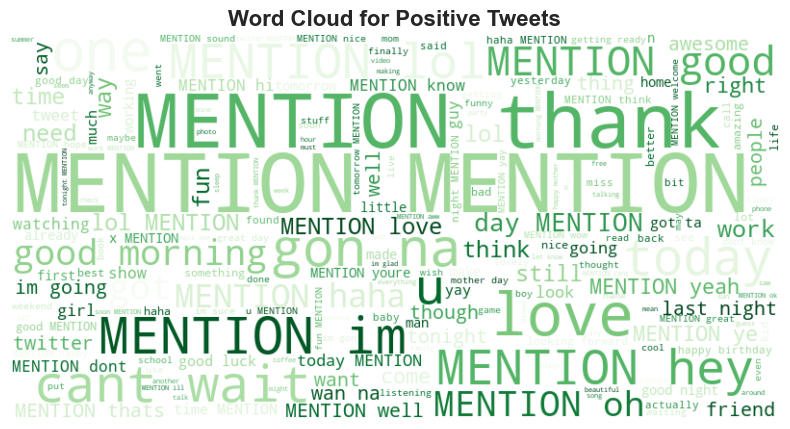

In [38]:
# Positive Tweets word cloud

# Filter only positive tweets (target == 4)
positive_tweets = preprocessed_tweets[preprocessed_tweets['target'] == 4]['text']

# Combine all negative tweet text into a single string
text_blob = ' '.join(positive_tweets.astype(str))

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens',
    max_words=200
).generate(text_blob)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Tweets", fontsize=16, fontweight='bold')
plt.show()

In [39]:
# We now save the processed tweets to be used later in model development

"""
# Step 1: Save file inside Colab
processed_data_dir = "/content"  # Best practice for Colab
output_processed_file_path = os.path.join(processed_data_dir, 'preprocessed_tweets.csv')
preprocessed_tweets.to_csv(output_processed_file_path, index=False)

print(f"Preprocessed tweets saved to: {output_processed_file_path}")

# Step 2: Download Mac Downloads folder manually
files.download(output_processed_file_path)
"""

print("Save processed file in github as it is less than 100MB")

Save processed file in github as it is less than 100MB


In [40]:
processed_data_dir = "../processed_data"
os.makedirs(processed_data_dir, exist_ok=True)

output_processed_file_path = os.path.join(processed_data_dir, "preprocessed_tweets.csv")
preprocessed_tweets.to_csv(output_processed_file_path, index=False)

print(f"Preprocessed tweets saved to: {output_processed_file_path}")

Preprocessed tweets saved to: ../processed_data/preprocessed_tweets.csv


# **4. Model Selection and Preliminary Performance Testing**

The selection of TF-IDF + Logistic Regression, LSTM, and BERT for sentiment analysis of tweets is grounded in both established research and best practices in natural language processing. TF-IDF combined with Logistic Regression provides a strong and interpretable baseline, particularly effective for sparse and high-dimensional text data like tweets (Ramos, 2003; Wang & Manning, 2012). It has been widely used in sentiment analysis tasks due to its simplicity and effectiveness in capturing word importance without sequence modeling. LSTM (Long Short-Term Memory) networks, introduced by Hochreiter & Schmidhuber (1997), are well-suited for handling the sequential nature of text and capturing long-term dependencies, which enhances performance on informal and context-sensitive content such as tweets (Zhou et al., 2016). BERT (Bidirectional Encoder Representations from Transformers) by Devlin et al. (2019) represents the state-of-the-art in many NLP tasks, including sentiment analysis, due to its deep contextual understanding and bidirectional attention mechanism, making it particularly effective for nuanced sentiment interpretation in short texts. This multi-model evaluation approach allows us to compare performance across lexical, sequential, and contextual modeling strategies. Only after testing all three will we select the best-performing model based on predefined evaluation metrics, followed by full-scale training and final evaluation, as recommended in model selection best practices (Sammut & Webb, 2017; Zhang et al., 2021). This ensures robustness, fairness, and optimal utilization of resources.

**References:**

* Ramos, J. (2003). Using TF-IDF to determine word relevance in document queries.
* Wang, S., & Manning, C. D. (2012). Baselines and Bigrams: Simple, Good Sentiment and Topic Classification.
* Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural Computation.
* Zhou, P., et al. (2016). Attention-Based Bidirectional LSTM Networks for Relation Classification.
* Devlin, J., et al. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding.
* Sammut, C., & Webb, G. I. (2017). Encyclopedia of Machine Learning and Data Mining.
* Zhang, Y., et al. (2021). A Comprehensive Review on Deep Learning for Text Classification.


In [41]:
# importing all libraries here

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import gdown
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [42]:
# Here, we begin by loading the processed dataset
"""
os.makedirs("../data", exist_ok=True)

file_id = "1LiS2ltl2XfITCamIrERkaa69OKKKoR_r"
url = f"https://drive.google.com/uc?id={file_id}"
output = "../data/preprocessed_tweets.csv"

gdown.download(url, output, quiet=False)
"""

print("Next, let's load the processed data saved in previous steps")

Next, let's load the processed data saved in previous steps


In [43]:
# Read the preprocessed tweet dataset and assign column names
#Tweets = pd.read_csv("../data/preprocessed_tweets.csv", header=None, names=["text", "target"])
Tweets = pd.read_csv("../processed_data/preprocessed_tweets.csv", header=None, names=["text", "target"])

# Drop any rows where 'text' or 'target' is null
Tweets = Tweets.dropna(subset=["text", "target"])

# Replace 'MENTION' with 'mentionuser' in the 'text' column
Tweets['text'] = Tweets['text'].str.replace('MENTION', 'mentionuser', regex=False)


Tweets.head()

/var/folders/5m/q16b86r92zgbmjpxpdx4ghfw0000gn/T/ipykernel_1799/2798388662.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  Tweets = pd.read_csv("../processed_data/preprocessed_tweets.csv", header=None, names=["text", "target"])


,text,target
0,text,target
1,mentionuser thats bummer shoulda got david car...,0
2,upset cant update facebook texting might cry r...,0
3,mentionuser dived many time ball managed save ...,0
4,whole body feel itchy like fire,0


#### Next we take first 70% of each negative and positive tweets for training, 15% for validation, and 15% for testing.
Sampling sould be done in a way that respects tweets length distribution.

This way we make sure all models are trained and validated using the same dataset and we have a good ground for fair comparison.

This step is valid because we showed in EDA section that negative and positive tewwts are equally distributed.

In [44]:
# Define bins and labels from the bar chart in our EDA
bin_edges = [0, 20, 40, 60, 80, 100, 120, 140]
bin_labels = ['0–20', '21–40', '41–60', '61–80', '81–100', '101–120', '121–140']

# Step 1: Assign length buckets safely
def assign_length_buckets(df):
    df = df.copy()
    df['text'] = df['text'].fillna('').astype(str)  # Ensure no NaNs
    df['text_length'] = df['text'].str.len()
    df['length_bucket'] = pd.cut(
        df['text_length'],
        bins=bin_edges,
        labels=bin_labels,
        right=True,
        include_lowest=True
    )
    df = df.dropna(subset=['length_bucket'])  # Drop any that didn't fall in bin
    return df

# Step 2: Stratified split function
def stratified_split_by_length_bucket(df_class, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    df_class = assign_length_buckets(df_class)

    # Split into train and temp
    train_df, temp_df = train_test_split(
        df_class,
        test_size=1 - train_ratio,
        stratify=df_class['length_bucket'],
        random_state=42
    )

    # Split temp into validation and test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_df, test_df = train_test_split(
        temp_df,
        test_size=1 - val_ratio_adjusted,
        stratify=temp_df['length_bucket'],
        random_state=42
    )

    return train_df.drop(columns='length_bucket'), val_df.drop(columns='length_bucket'), test_df.drop(columns='length_bucket')

# Step 3: Filter by sentiment
df_neg = Tweets[Tweets['target'] == 0]
df_pos = Tweets[Tweets['target'] == 4]

# Step 4: Apply stratified splitting
neg_train, neg_val, neg_test = stratified_split_by_length_bucket(df_neg)
pos_train, pos_val, pos_test = stratified_split_by_length_bucket(df_pos)

# Step 5: Combine and shuffle
train_df = pd.concat([neg_train, pos_train]).sample(frac=1, random_state=42).reset_index(drop=True)
val_df = pd.concat([neg_val, pos_val]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([neg_test, pos_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Step 6: Extract input and labels
X_train = train_df['text']
y_train = train_df['target']
X_val = val_df['text']
y_val = val_df['target']
X_test = test_df['text']
y_test = test_df['target']

# Final check
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)
print("X_train shape:", X_train.shape, "| y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "| y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "| y_test shape:", y_test.shape)


Train shape: (936183, 3)
Validation shape: (200611, 3)
Test shape: (200612, 3)
X_train shape: (936183,) | y_train shape: (936183,)
X_val shape: (200611,) | y_val shape: (200611,)
X_test shape: (200612,) | y_test shape: (200612,)


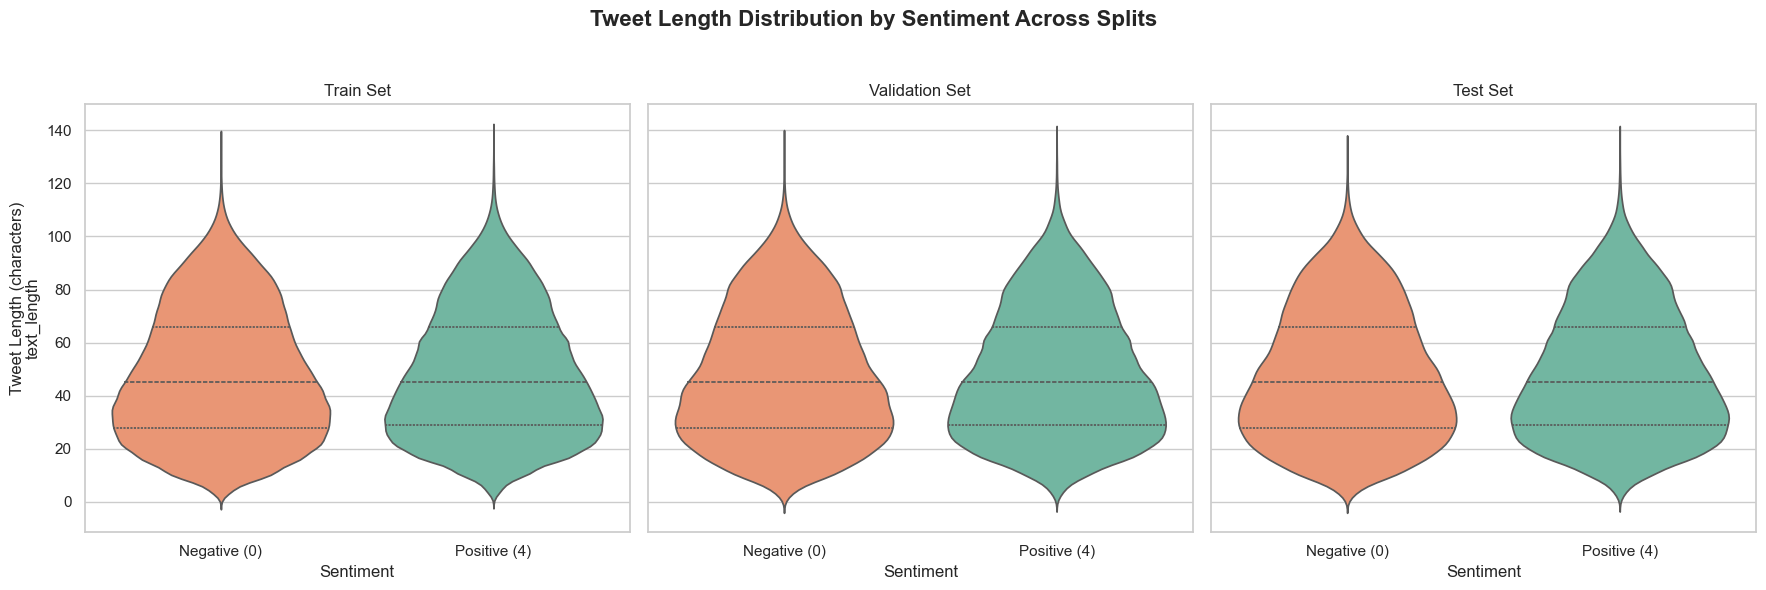

In [45]:
# here we validate the distributions are identical and intact

# Combine text + label for plotting, and calculate text length
train_plot_df = pd.concat([X_train, y_train], axis=1).copy()
val_plot_df = pd.concat([X_val, y_val], axis=1).copy()
test_plot_df = pd.concat([X_test, y_test], axis=1).copy()

# Ensure text_length column is present
train_plot_df['text_length'] = train_plot_df['text'].str.len()
val_plot_df['text_length'] = val_plot_df['text'].str.len()
test_plot_df['text_length'] = test_plot_df['text'].str.len()

# Ensure 'target' is integer (not string) for palette mapping
train_plot_df['target'] = train_plot_df['target'].astype(int)
val_plot_df['target'] = val_plot_df['target'].astype(int)
test_plot_df['target'] = test_plot_df['target'].astype(int)

# Define sentiment color palette
sentiment_palette = {
    0: '#fc8d62',  # Negative
    4: '#66c2a5'   # Positive
}

# Set up subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot train
sns.violinplot(ax=axes[0], data=train_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[0].set_title('Train Set')
axes[0].set_xlabel('Sentiment')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Plot validation
sns.violinplot(ax=axes[1], data=val_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Sentiment')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Plot test
sns.violinplot(ax=axes[2], data=test_plot_df, x='target', y='text_length', hue='target', palette=sentiment_palette, inner='quartile', legend=False)
axes[2].set_title('Test Set')
axes[2].set_xlabel('Sentiment')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Negative (0)', 'Positive (4)'])

# Shared Y-label and layout
fig.supylabel('Tweet Length (characters)', fontsize=12)
plt.suptitle("Tweet Length Distribution by Sentiment Across Splits", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### After we made sure we have good and valid splits, we now move on to modeling part, where we will only use training and validation set for model comparison and selection, ***testing dataset will only be used in model performance evaluation section***


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>4.1 Baseline Model – TF-IDF + Logistic Regression</strong></h2>
  <p style="color:#333333;">TF-IDF vectorization + logistic regression as a benchmark.</p>
</div>


In [46]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [47]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ariesslin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [48]:
# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization and stopword removal
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [49]:
# Load dataset from the preprocessed data
Tweets_copy_df = Tweets.copy()
Tweets_copy_df.head()

,text,target
0,text,target
1,mentionuser thats bummer shoulda got david car...,0
2,upset cant update facebook texting might cry r...,0
3,mentionuser dived many time ball managed save ...,0
4,whole body feel itchy like fire,0


In [50]:


# Map sentiment labels (0=negative, 4=positive) to (0=negative, 1=positive)
#Tweets_copy_df['target'] = Tweets_copy_df['target'].map({0: 0, 4: 1})

# Preprocess text
Tweets_copy_df['clean_text'] = Tweets_copy_df['text'].apply(preprocess_text)

In [51]:
# Split data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    Tweets_copy_df['clean_text'], Tweets_copy_df['target'], test_size=0.2, random_state=42
)
print("X_train shape:", X_train_1.shape, "| y_train shape:", y_train_1.shape)
print("X_test shape:", X_test_1.shape, "| y_test shape:", y_test_1.shape)

X_train shape: (1279596,) | y_train shape: (1279596,)
X_test shape: (319900,) | y_test shape: (319900,)


In [52]:
# Create pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2) )
    ),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced')
    )
])

In [53]:
y_train_1.head()

174335     0
306270     0
1518505    4
1258400    4
508917     0
Name: target, dtype: object

In [54]:
print("Missing values in y_train:", y_train_1.isna().sum())
print("Unique values before conversion:", y_train_1.unique())
print("Missing values in y_train:", y_test_1.isna().sum())
print("Unique values before conversion:", y_test_1.unique())

Missing values in y_train: 0
Unique values before conversion: ['0' 0 4 'target']
Missing values in y_train: 0
Unique values before conversion: [4 0 '0']


In [55]:
y_train_1 = y_train_1.apply(lambda x: 0 if x=='target' else x)

In [56]:
print("Unique values before conversion:", y_train_1.unique())

Unique values before conversion: ['0' 0 4]


In [57]:
# Ensure your target variable is properly formatted
y_train_1 = pd.to_numeric(y_train_1, errors='coerce').astype(int)
y_test_1 = pd.to_numeric(y_test_1, errors='coerce').astype(int)

# Verify the conversion
print("Unique values in y_train:", np.unique(y_train_1))
print("Data type:", y_train_1.dtype)
print("Unique values in y_train:", np.unique(y_test_1))
print("Data type:", y_test_1.dtype)

# Train model
pipeline.fit(X_train_1, y_train_1)

Unique values in y_train: [0 4]
Data type: int64
Unique values in y_train: [0 4]
Data type: int64


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [58]:
# Evaluate
y_pred_1 = pipeline.predict(X_test_1)
print("Accuracy:", accuracy_score(y_test_1, y_pred_1))
print("\nClassification Report:")
print(classification_report(y_test_1, y_pred_1))

# Example prediction
test_tweet = "I love this product! It's amazing."
clean_test = preprocess_text(test_tweet)
print("\nTest Tweet Prediction:", pipeline.predict([clean_test])[0])

Accuracy: 0.7844076273835574

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159404
           4       0.77      0.81      0.79    160496

    accuracy                           0.78    319900
   macro avg       0.78      0.78      0.78    319900
weighted avg       0.78      0.78      0.78    319900


Test Tweet Prediction: 4


In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def tune_hyperparameters(X_train, y_train):
    """
    Perform hyperparameter tuning for TF-IDF + Logistic Regression pipeline

    Args:
        X_train: Training text data
        y_train: Training labels

    Returns:
        Best estimator and best parameters found
    """
    # Define the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Define parameter grid
    param_grid = {
        'tfidf__max_features': [5000, 10000, 20000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],  # unigrams or unigrams+bigrams
        'tfidf__min_df': [1, 5],  # minimum document frequency
        'tfidf__max_df': [0.7, 0.9],  # maximum document frequency (ignore too common words)
        'clf__C': [0.1, 1, 10],  # inverse of regularization strength
        'clf__penalty': ['l1', 'l2'],  # regularization type
        'clf__class_weight': [None, 'balanced']
    }

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,  # 3-fold cross-validation
        scoring='f1_weighted',  # can change to 'accuracy' or other metrics
        n_jobs=-1,  # use all available CPU cores
        verbose=1
    )

    # Perform the grid search
    print("Starting grid search...")
    grid_search.fit(X_train, y_train)

    # Print results
    print("\nBest parameters found:")
    print(grid_search.best_params_)

    print("\nBest cross-validation score: {:.2f}".format(grid_search.best_score_))

    return grid_search.best_estimator_, grid_search.best_params_


In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import os
import joblib

def tune_hyperparameters_with_cache(X_train, y_train, cache_dir='./cache'):
    """
    Perform hyperparameter tuning with memory caching

    Args:
        X_train: Training text data
        y_train: Training labels
        cache_dir: Directory to store cached computations

    Returns:
        Best estimator and best parameters found
    """
    # Create cache directory if it doesn't exist
    os.makedirs(cache_dir, exist_ok=True)

    # Clear previous cache to ensure fresh start
    joblib.Memory(location=cache_dir, verbose=0).clear()

    # Define the pipeline with memory caching
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ], memory=joblib.Memory(location=cache_dir, verbose=0))

    # Define parameter grid (same as before)
    param_grid = {
        'tfidf__max_features': [5000, 10000, 20000],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'tfidf__min_df': [1, 5],
        'tfidf__max_df': [0.7, 0.9],
        'clf__C': [0.1, 1, 10],
        'clf__penalty': ['l1', 'l2'],
        'clf__class_weight': [None, 'balanced']
    }

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )

    # Perform the grid search
    print(f"Starting grid search with caching at {cache_dir}...")
    grid_search.fit(X_train, y_train)

    # Print results
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print("\nBest cross-validation score: {:.2f}".format(grid_search.best_score_))

    return grid_search.best_estimator_, grid_search.best_params_

In [ ]:
# Tune hyperparameters and test the best_model to predict a sample text:
best_model, best_params = tune_hyperparameters(X_train, y_train)
#best_model, best_params = tune_hyperparameters_with_cache(X_train, y_train, cache_dir='./tfidf_cache')
#cache inspection
#cache = joblib.Memory(location='./cache')
#print(cache.reduce_size())

Starting grid search...
Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [ ]:
#clean cache
#import shutil
#shutil.rmtree('./cache')  # Complete cleanup

In [ ]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>4.2 LSTM Model</strong></h2>
  <p style="color:#333333;">Bidirectional LSTM with pre-trained embeddings (e.g., Wrod2Vec).</p>
</div>

In [ ]:
# Step 1: Reinstall compatible keras
#!pip uninstall -y keras
#!pip install -q keras==3.8.0

### Use !pip install -r "../requirements.txt" at the beginning of the notebook instead

In [ ]:
# loading all libraries here
import numpy as np
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# we tokenize each tweet for training and testing data

training_df = train_plot_df.copy()
val_df = val_plot_df.copy()

# Apply gensim's tokenizer
tokenized_train = training_df['text'].dropna().astype(str).apply(simple_preprocess).tolist()
tokenized_val = val_df['text'].dropna().astype(str).apply(simple_preprocess).tolist()

In [ ]:
# first train our Word2Vec on the Tokenized Data

embedding_dim = 100

model_LSTM = Word2Vec(
    sentences=tokenized_train,
    vector_size=embedding_dim,
    window=10,
    min_count=2,
    sg=1,  # Skip-gram
    seed=42,
    workers=10
)

word2vec_model = model_LSTM.wv  # Use KeyedVectors for embedding lookup

In [ ]:
# Prepare for Keras Tokenizer

# Join tokens back into space-separated strings
tokenized_train_texts = [' '.join(tokens) for tokens in tokenized_train]
tokenized_val_texts = [' '.join(tokens) for tokens in tokenized_val]

# Fit tokenizer on training texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_train_texts)

word_index = tokenizer.word_index

In [ ]:
# Next, we Build the Embedding Matrix

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
found = 0

for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
        found += 1

print(f"Words matched: {found}/{len(word_index)}")

This will cause some major issues as we train the model, in fact by several experiments, the model never actually really learned, i could not even make it overfit.
This means that likely our Word2Vec trained on clean tokens but Tokenizer worked on noisy ones (e.g., lollll, omggg)


In [ ]:
# for now, i will only limit tokenisation on trained words

# Prepare for Keras Tokenizer

# Join tokens back into space-separated strings
tokenized_train_texts = [' '.join(tokens) for tokens in tokenized_train]
tokenized_val_texts = [' '.join(tokens) for tokens in tokenized_val]

# Fit tokenizer on training texts
tokenizer = Tokenizer(num_words=82014)
tokenizer.fit_on_texts(tokenized_train_texts)

word_index = tokenizer.word_index

In [ ]:
# Next, we Build the Embedding Matrix

embedding_matrix = np.zeros((tokenizer.num_words, embedding_dim))

found = 0
for word, i in tokenizer.word_index.items():
    if i >= tokenizer.num_words:
        continue
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
        found += 1
print(f"Words matched: {found}/{tokenizer.num_words}")


In [ ]:
# Next, Convert Texts to Sequences and Pad

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(tokenized_train_texts)
X_val_seq = tokenizer.texts_to_sequences(tokenized_val_texts)

# Define max sequence length
max_len = max(len(seq) for seq in X_train_seq)

# Pad sequences to same length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')


In [ ]:
# We convert the target to float, and encode 0 and 1 to accommodate for sigmoid:

y_train = np.where(y_train == 4, 1.0, 0.0).astype(np.float32)
y_val = np.where(y_val == 4, 1.0, 0.0).astype(np.float32)


In [ ]:
# First, we reduce our model to a small Sanity Test

# Use a very small subset to test if model can overfit
X_small = X_train_pad[:100]
y_small = y_train[:100]

# Sanity check: Create a simple model
model = Sequential()
model.add(Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=X_small.shape[1],
    trainable=True
))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Fit to a small subset to test if it can overfit
history = model.fit(X_small, y_small, epochs=20, batch_size=10, verbose=2)

In [ ]:
############# ---------- The output below is from older test execution --------------------

In [ ]:
# Check Max Index vs Embedding Size

print("Max index in padded input:", np.max(X_train_pad))
print("Embedding matrix shape:", embedding_matrix.shape)


In [ ]:
# Visualize Embedding Lookups

row = X_train_pad[0]  # a tokenized tweet
vecs = embedding_matrix[row]
print("Any rows all zero?", np.any(np.all(vecs == 0, axis=1)))  # Expect False
print("How many zero vectors in one tweet?", np.sum(np.all(vecs == 0, axis=1)))


#### quick debugging insights

That means ~74% of tokens in a tweet have no embeddings, the model is learning from almost nothing.

Why?
Because those tokens likely correspond to words not found in Word2Vec vocabulary. This means our embedding matrix isn't covering the actual tokens used in training.

In [ ]:
############# ---------------------------------------------------------------------------

In [ ]:
# Now, we build our model

# Define model
LSTMmodel = Sequential()

# 1. Embedding layer
LSTMmodel.add(Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
))

# 2. First LSTM
LSTMmodel.add(Bidirectional(LSTM(265, return_sequences=True)))

LSTMmodel.add(Dropout(0.5))

# 3. Second LSTM
LSTMmodel.add(Bidirectional(LSTM(128)))

# 4. Dropout
LSTMmodel.add(Dropout(0.3))

# 5. Output
LSTMmodel.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = Nadam(learning_rate=0.001)
LSTMmodel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Show summary
LSTMmodel.summary()

In [ ]:
# Next we train our model, and then visualize performance

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = LSTMmodel.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=500,
    callbacks=[early_stop]
)

# Save the model and download
LSTMmodel.save("sentiment_lstm_model.keras")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

______________________________________________________________________________________________________________________________


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>4.3 BERT Model</strong></h2>
  <p style="color:#333333;">Fine-tuning DistilBERT or similar transformer model (if feasible).</p>
</div>



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>4.4 Model Comparison and Selection </strong></h2>
  <p style="color:#333333;">Evaluate using accuracy, precision, recall, F1-score, confusion matrix, and ROC curve.</p>
</div>


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>4.5 Final Model Training </strong></h2>
  <p style="color:#333333;">Evaluate using accuracy, precision, recall, F1-score, confusion matrix, and ROC curve.</p>
</div>


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>5. Model Evaluation </strong></h2>
  <p style="color:#333333;">Evaluate using accuracy, precision, recall, F1-score, confusion matrix, and ROC curve.</p>
</div>



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>6. Conclusion</strong></h2>
  <p style="color:#333333;">Summarize findings and insights, discuss trade-offs, and generalization potential.</p>
</div>



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>9. Future Work</strong></h2>
  <p style="color:#333333;">Suggest future extensions like streaming integration or domain adaptation.</p>
</div>
